# DML ATT Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATT       | Yes        |

We will estimate Average Treatment Effect on Treated (ATT) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Example that generates observational data with a nonlinear outcome model, nonlinear treatment assignment, and a heterogeneous (nonlinear) treatment effect tau(X). This setup ensures that ATT ≠ ATE in general. It also shows how to compute the “ground-truth” ATT from the generated data.

In [1]:
# Nonlinear ATT data generation with heterogeneous effects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from causalkit.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

# 1) Confounders and their distributions
#    These names define the column order in X for the custom functions.
confounder_specs = [
    {"name": "tenure_months",     "dist": "normal",   "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal",   "mu": 5,  "sd": 2},
    {"name": "spend_last_month",  "dist": "uniform",  "a": 0,   "b": 200},
    {"name": "premium_user",      "dist": "bernoulli","p": 0.25},
    {"name": "urban_resident",    "dist": "bernoulli","p": 0.60},
]

# Indices (for convenience inside g_y, g_t, tau)
TENURE, SESS, SPEND, PREMIUM, URBAN = range(5)

# 2) Nonlinear baseline for outcome f_y(X) = X @ beta_y + g_y(X)
#    Keep a modest linear part and add meaningful nonlinearities.
beta_y = np.array([
    0.03,   # tenure_months
    0.20,   # avg_sessions_week
    0.01,   # spend_last_month
    1.20,   # premium_user
    0.60,   # urban_resident
], dtype=float)

def g_y(X: np.ndarray) -> np.ndarray:
    # Nonlinearities and interactions in outcome baseline
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    return (
        1.2 * np.sin(2.0 * np.pi * tenure_years)          # seasonal-ish tenure pattern
        + 0.02 * (sessions - 5.0) ** 2                    # convex effect of sessions
        + 0.0015 * (spend - 100.0) * (sessions - 5.0)     # spend × sessions interaction
        + 0.4 * premium * (sessions - 5.0)                # premium × sessions interaction
        + 0.3 * urban * np.tanh((spend - 100.0) / 50.0)   # nonlinear spend effect differs by urban
    )

# 3) Nonlinear treatment score f_t(X) = X @ beta_t + g_t(X)
beta_t = np.array([
    0.010,  # tenure_months
    0.12,   # avg_sessions_week
    0.001,  # spend_last_month
    0.80,   # premium_user
    0.25,   # urban_resident
], dtype=float)

def g_t(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Smoothly increasing selection with spend; interactions make selection non-separable
    soft_spend = 1.2 * np.tanh((spend - 80.0) / 40.0)
    return (
        0.6 * soft_spend
        + 0.15 * (sessions - 5.0) * (tenure_years - 2.0)
        + 0.25 * premium * (urban - 0.5)
    )

# 4) Heterogeneous, nonlinear treatment effect tau(X) on the natural scale (continuous outcome)
def tau_fn(X: np.ndarray) -> np.ndarray:
    tenure_years = X[:, TENURE] / 12.0
    sessions = X[:, SESS]
    spend = X[:, SPEND]
    premium = X[:, PREMIUM]
    urban = X[:, URBAN]

    # Base effect + stronger effect for higher sessions and premium users,
    # diminishes with tenure, mild modulation by spend and urban
    tau = (
        1.0
        + 0.8 * (1.0 / (1.0 + np.exp(-(sessions - 5.0))))    # sigmoid in sessions
        + 0.5 * premium
        - 0.6 * np.clip(tenure_years / 5.0, 0.0, 1.0)        # taper with long tenure
        + 0.2 * urban * (spend - 100.0) / 100.0
    )
    # Optional: keep it in a reasonable range
    return np.clip(tau, 0.2, 2.5)

# 5) Noise and prevalence
sigma_y = 1
target_t_rate = 0.35  # enforce ~35% treated via intercept calibration

# 6) Build generator
gen = CausalDatasetGenerator(
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_t_rate=target_t_rate,
    seed=42,
    # Confounders
    confounder_specs=confounder_specs,
    # Outcome/treatment structure
    beta_y=beta_y,
    beta_t=beta_t,
    g_y=g_y,
    g_t=g_t,
    # Heterogeneous effect
    tau=tau_fn,
)

# 7) Generate data (full dataframe includes ground-truth columns: propensity, mu0, mu1, cate)
n = 10000
generated_df = gen.generate(n)

# Ground-truth ATT (on the natural scale): E[tau(X) | T=1] = mean CATE among the treated
true_att = float(generated_df.loc[generated_df["t"] == 1, "cate"].mean())
print(f"Ground-truth ATT from the DGP: {true_att:.3f}")

# 8) Wrap as CausalData for downstream workflows (keeps only y, t, and specified confounders)
causal_data = CausalData(
    df=generated_df,
    treatment="t",
    outcome="y",
    confounders=[
        "tenure_months",
        "avg_sessions_week",
        "spend_last_month",
        "premium_user",
        "urban_resident",
    ],
)

# Peek at the analysis-ready view
causal_data.df.head()

Ground-truth ATT from the DGP: 1.377


,y,t,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,2.655677,0.0,27.656605,1.850801,143.970294,1.0,0.0
1,3.152743,0.0,11.520191,9.781762,53.161804,0.0,0.0
2,8.967707,1.0,33.005414,8.592617,166.282514,0.0,1.0
3,2.876487,0.0,35.286777,3.342658,143.303974,1.0,0.0
4,2.206921,0.0,0.587578,8.202781,30.904851,0.0,1.0


## EDA


In [2]:
from causalkit.eda import CausalEDA
eda = CausalEDA(causal_data)

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# shape of data
eda.data_shape()

{'n_rows': 100000, 'n_columns': 7}

In [4]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,65201,3.208326,1.703285,-2.639166,1.054901,2.021541,3.161247,4.323998,5.397061,11.742213
1.0,34799,5.333375,2.071834,-1.839315,2.803046,3.883652,5.199704,6.641531,8.054006,16.219175


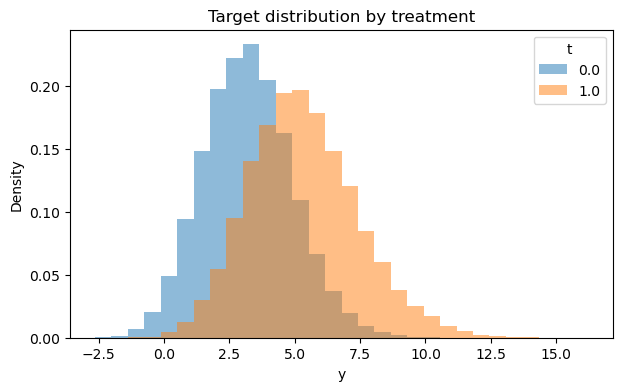

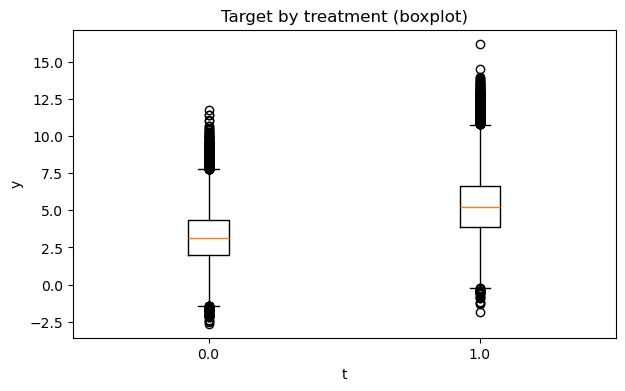

In [5]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [6]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
spend_last_month,89.590244,119.444655,29.854411,0.539664
premium_user,0.200794,0.338832,0.138037,0.314816
avg_sessions_week,4.860831,5.276371,0.415541,0.208015
urban_resident,0.581019,0.645478,0.064460,0.132648
tenure_months,23.419010,24.942602,1.523591,0.126622


In [7]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.7016


In [8]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.00517, 'share_above': 0.00057, 'flag': False}


In [9]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__avg_sessions_week,0.000367,0.210221,1.233951,0.049074,0.000083
1,num__tenure_months,-0.000316,0.147956,1.159462,0.034270,-0.000072
2,num__premium_user,-0.000088,0.301134,1.351390,0.071026,-0.000020
3,num__spend_last_month,0.000064,0.567319,1.763533,0.136852,0.000015
4,num__urban_resident,-0.000028,0.142605,1.153274,0.033008,-0.000006


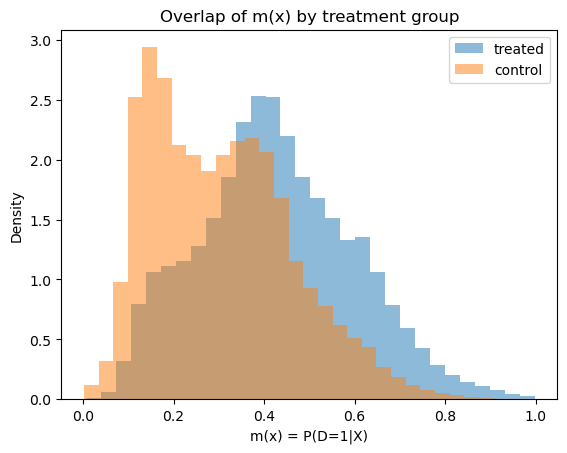

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 1.1814364917962212, 'mae': 0.9446571433391119}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,avg_sessions_week,0.000568
1,spend_last_month,-0.000420
2,tenure_months,-0.000165
3,urban_resident,0.000106
4,premium_user,-0.000089


# Inference

Now time to estimate ATE with Double Machine Learning

In [13]:
from causalkit.inference.att import dml_att

# Estimate Average Treatment Effect (ATT)
att_result = dml_att(causal_data, normalize_ipw = True)

In [20]:
from causalkit.inference.ate import dml_ate
#
# # Estimate Average Treatment Effect (ATE)
ate_result = dml_ate(causal_data, normalize_ipw = True)

In [21]:
# ate_result

Real ATT is 1.385

## Refutation

In [22]:
from causalkit.refutation.overlap.overlap_validation import overlap_report_from_result

In [23]:
report = overlap_report_from_result(ate_result)

In [24]:
report

{'n': 100000,
 'n_treated': 34799,
 'p1': 0.34799,
 'eps': (0.01, 0.02),
 'edge_mass': {'share_below_001': 0.0,
  'share_above_001': 0.0,
  'share_below_002': 0.00105,
  'share_above_002': 8e-05,
  'min_m': 0.01,
  'max_m': 0.99},
 'edge_mass_by_arm': {'share_below_001_D1': 0.0,
  'share_above_001_D0': 0.0,
  'share_below_002_D1': 5.74729158883876e-05,
  'share_above_002_D0': 0.0},
 'ks': 0.29205002935835916,
 'auc': 0.7018321049722442,
 'ate_ipw': {'sum_w1': 34799.00000000001,
  'sum_w0': 65200.99999999999,
  'mean_w1': 1.0,
  'mean_w0': 1.0,
  'target_sum_w1': 34799.0,
  'target_sum_w0': 65201.0,
  'target_mean_w': 1.0},
 'ate_ess': {'ess_w1': 23832.616461089026,
  'ess_w0': 57731.98119330066,
  'ess_ratio_w1': 0.6848649806341857,
  'ess_ratio_w0': 0.8854462537890624},
 'ate_tails': {'w1': {'q50': 0.8152623669663314,
   'q95': 2.2606912167786657,
   'q99': 6.269066031038053,
   'max': 32.569024460221144,
   'median': 0.8152623669663314},
  'w0': {'q50': 0.9118210600797818,
   'q95': 

In [25]:
print(report["flags"])

{'edge_mass_001': 'GREEN', 'edge_mass_002': 'GREEN', 'ks': 'YELLOW', 'auc': 'GREEN', 'ipw_sum_w1': 'GREEN', 'ipw_sum_w0': 'GREEN', 'ess_w1': 'GREEN', 'ess_w0': 'GREEN', 'tails_w1': 'YELLOW', 'tails_w0': 'YELLOW', 'att_identity': 'GREEN', 'clip_m': 'GREEN'}
